In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score

Using TensorFlow backend.


In [2]:
# RBLSTM

LAYERS = 3
MAX_POWER = 12
FOLDS = 5
PADDING = 50


input_data = pk.load(open('input_data.pkl', 'rb'))
target_data = pk.load(open('target_data.pkl', 'rb'))

layers = []
dimention = []
auc = []
kappa = []

for lay in range(1,LAYERS+1):
    for dim in np.power(2, np.arange(MAX_POWER+1)):
        print(f'layers: {lay}, nodes: {dim}')
        aucs = []
        kappas = []
        
        # Prepare training batches
        bilstm_input = []
        bilstm_target = []
        for i, t in zip(input_data, target_data):
            bilstm_input.append(np.concatenate([np.zeros((PADDING-1, i.shape[1])), i])[:PADDING,:])
            bilstm_target.append(np.argmax(t))
        bilstm_input = np.array(bilstm_input)
        bilstm_target = np.array(bilstm_target)
        
        # Prepare k-fold training and test sets
        skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
        for train_index, test_index in skf.split(bilstm_input, bilstm_target):
            bilstm_target[train_index.astype(int)]
            X_train_raw, X_test_raw = bilstm_input[train_index], bilstm_input[test_index]
            y_train_raw, y_test_raw = bilstm_target[train_index], bilstm_target[test_index]
            
            X_train = np.stack(X_train_raw)
            X_test = np.stack(X_test_raw)
            
            y_train = np.zeros((y_train_raw.size, y_train_raw.max()+1))
            y_train[np.arange(y_train_raw.size),y_train_raw] = 1
            y_test = np.zeros((y_test_raw.size, y_test_raw.max()+1))
            y_test[np.arange(y_test_raw.size),y_test_raw] = 1
            
            # Make the LSTM
            bilstm = Sequential()
            if lay == 1:
                bilstm.add(Bidirectional(LSTM(dim, activation='tanh'), input_shape=(PADDING, input_data[0].shape[1])))
            elif lay == 2:
                bilstm.add(Bidirectional(LSTM(dim, activation='tanh', return_sequences=True), input_shape=(PADDING, input_data[0].shape[1])))
                bilstm.add(Bidirectional(LSTM(dim, activation='tanh')))
            elif lay == 3:
                bilstm.add(Bidirectional(LSTM(dim, activation='tanh', return_sequences=True), input_shape=(PADDING, input_data[0].shape[1])))
                bilstm.add(Bidirectional(LSTM(dim, activation='tanh', return_sequences=True)))
                bilstm.add(Bidirectional(LSTM(dim, activation='tanh')))
            bilstm.add(Dense(4, activation='sigmoid'))
        
            # Train the model
            bilstm.compile(optimizer='adam', loss='categorical_crossentropy')
            es = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0, restore_best_weights=True)]
            bilstm.fit(X_train, y_train, epochs=1000, batch_size=1, validation_split=0.25, callbacks=es, verbose=True)
            
            # Get the average auc and kappa for all affects and folds
            y_pred = bilstm.predict(X_test, batch_size=1)
            for y_t, y_p in zip(y_test.T, y_pred.T):
                aucs.append(roc_auc_score(y_t, y_p))
                kappas.append(cohen_kappa_score(y_t, np.around(y_p)))
        layers.append(lay)
        dimention.append(dim)
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))
        print(f'auc: {auc[-1]}')
        print(f'kappa: {kappa[-1]}')

layers: 1, nodes: 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1854 samples, validate on 618 samples
Epoch 1/1000
1854/1854 [==============================] - 92s 50ms/step - loss: 0.8071 - val_loss: 0.6282
Epoch 2/1000
1854/1854 [==============================] - 92s 49ms/step - loss: 0.6408 - val_loss: 0.6228
Epoch 3/1000
1854/1854 [==============================] - 92s 49ms/step - loss: 0.6350 - val_loss: 0.6288
Epoch 4/1000
1854/1854 [==============================] - 92s 49ms/step - loss: 0.6331 - val_loss: 0.6309
Epoch 5/1000
1854/1854 [==============================] - 92s 50ms/step - loss: 0.6320 - val_loss: 0.6359
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 91s 49ms/step - loss: 0.8009 - val_loss: 0.6518
Epoch 2/1000
1854/1854 [==============================] - 99s 53ms/step - loss: 0.6405 - val_loss: 0.6392
Epoch 3/1000
1854/1854 [=========================

1854/1854 [==============================] - 99s 54ms/step - loss: 0.6325 - val_loss: 0.6263
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 100s 54ms/step - loss: 0.6956 - val_loss: 0.6587
Epoch 2/1000
1854/1854 [==============================] - 99s 53ms/step - loss: 0.6284 - val_loss: 0.6588
Epoch 3/1000
1854/1854 [==============================] - 99s 53ms/step - loss: 0.6253 - val_loss: 0.6539
Epoch 4/1000
1854/1854 [==============================] - 99s 53ms/step - loss: 0.6226 - val_loss: 0.6605
Epoch 5/1000
1854/1854 [==============================] - 99s 53ms/step - loss: 0.6206 - val_loss: 0.6590
Epoch 6/1000
1854/1854 [==============================] - 99s 53ms/step - loss: 0.6178 - val_loss: 0.6640
Train on 1856 samples, validate on 619 samples
Epoch 1/1000
1856/1856 [==============================] - 101s 54ms/step - loss: 0.7115 - val_loss: 0.6238
Epoch 2/1000
1856/1856 [==============================] - 100s 54ms/s

1857/1857 [==============================] - 94s 50ms/step - loss: 0.6351 - val_loss: 0.6327
Epoch 3/1000
1857/1857 [==============================] - 94s 51ms/step - loss: 0.6307 - val_loss: 0.6391
Epoch 4/1000
1857/1857 [==============================] - 94s 50ms/step - loss: 0.6273 - val_loss: 0.6550
Epoch 5/1000
1857/1857 [==============================] - 94s 50ms/step - loss: 0.6256 - val_loss: 0.6476
auc: 0.5834080193242608
kappa: 0.0
layers: 1, nodes: 32
Train on 1854 samples, validate on 618 samples
Epoch 1/1000
1854/1854 [==============================] - 95s 51ms/step - loss: 0.6588 - val_loss: 0.6260
Epoch 2/1000
1854/1854 [==============================] - 94s 50ms/step - loss: 0.6373 - val_loss: 0.6401
Epoch 3/1000
1854/1854 [==============================] - 94s 50ms/step - loss: 0.6282 - val_loss: 0.6649
Epoch 4/1000
1854/1854 [==============================] - 94s 51ms/step - loss: 0.6219 - val_loss: 0.6398
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
18

1856/1856 [==============================] - 95s 51ms/step - loss: 0.6426 - val_loss: 0.6287
Epoch 4/1000
1856/1856 [==============================] - 95s 51ms/step - loss: 0.6407 - val_loss: 0.6220
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 99s 53ms/step - loss: 0.6660 - val_loss: 0.6456
Epoch 2/1000
1857/1857 [==============================] - 96s 52ms/step - loss: 0.6433 - val_loss: 0.6241
Epoch 3/1000
1857/1857 [==============================] - 96s 52ms/step - loss: 0.6310 - val_loss: 0.6426
Epoch 4/1000
1857/1857 [==============================] - 96s 52ms/step - loss: 0.6295 - val_loss: 0.6701
Epoch 5/1000
1857/1857 [==============================] - 96s 52ms/step - loss: 0.6235 - val_loss: 0.6574
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 98s 53ms/step - loss: 0.6578 - val_loss: 0.6581
Epoch 2/1000
1857/1857 [==============================] - 95s 51ms/step

1854/1854 [==============================] - 181s 98ms/step - loss: 1.0906 - val_loss: 1.0909
Epoch 3/1000
1854/1854 [==============================] - 181s 98ms/step - loss: 1.0845 - val_loss: 1.2750
Epoch 4/1000
1854/1854 [==============================] - 181s 98ms/step - loss: 1.1486 - val_loss: 1.3570
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 186s 100ms/step - loss: 1.0365 - val_loss: 1.2958
Epoch 2/1000
1854/1854 [==============================] - 182s 98ms/step - loss: 1.0381 - val_loss: 1.1101
Epoch 3/1000
1854/1854 [==============================] - 182s 98ms/step - loss: 1.0418 - val_loss: 1.1151
Epoch 4/1000
1854/1854 [==============================] - 182s 98ms/step - loss: 1.0608 - val_loss: 1.0262
Epoch 5/1000
1854/1854 [==============================] - 182s 98ms/step - loss: 1.0315 - val_loss: 1.0245
Epoch 6/1000
1854/1854 [==============================] - 182s 98ms/step - loss: 1.0304 - val_loss: 1.1149
Ep

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[4096,16384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_60/Adam/mul_23}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Mean_60/_11747]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[4096,16384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_60/Adam/mul_23}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

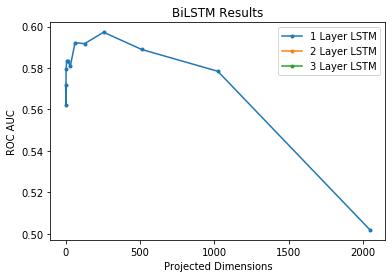

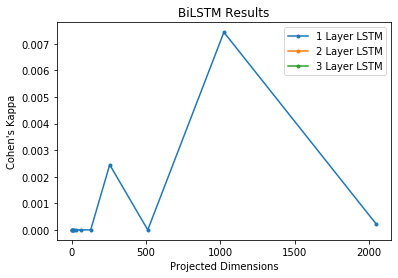

In [3]:
plt.figure()
for i in range(3):
    plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], auc[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('BiLSTM Results')
plt.legend()
plt.show()

plt.figure()
for i in range(3):
    plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], kappa[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer LSTM')
plt.xlabel('Projected Dimensions')
plt.ylabel('Cohen\'s Kappa')
plt.title('BiLSTM Results')
plt.legend()
plt.show()